# Timing Functions

This notebook has the results of timing various CSR functions.  It uses the data produced by the benchmark suite and saved in `bench.json`; to prepare that data, run:

    python -m pytest --benchmark-only

In [1]:
import json
import numpy as np
import scipy.sparse as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's load the benchmark data:

In [2]:
with open('bench.json', 'r') as jsf:
    data = json.load(jsf)
list(data.keys())

['machine_info', 'commit_info', 'benchmarks', 'datetime', 'version']

And define a function to get the various benchmark runs:

In [3]:
def get_runs(group, *params):
    marks = [b for b in data['benchmarks'] if b['group'] == group]
    ps = ['kernel'] + list(params)
    runs = {}
    for b in data['benchmarks']:
        if b['group'] != group:
            continue
        
        key = tuple(b['params'][p] for p in ps)
        runs[key] = pd.Series(b['stats']['data'], name='time')
    
    runs = pd.concat(runs, names=ps)
    runs = runs.reset_index(ps)
    runs = runs.reset_index(drop=True)
    return runs

In [4]:
get_runs('MultAB')

,kernel,time
0,scipy,0.000808
1,scipy,0.000846
2,scipy,0.000839
3,scipy,0.000808
4,scipy,0.000807
...,...,...
9148,numba,0.001661
9149,numba,0.001289
9150,numba,0.001265
9151,numba,0.001305


## Matrix Multiplication

Our first benchmark is a simple matrix multiplication.

In [5]:
mab = get_runs('MultAB')
mab.groupby('kernel')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
kernel,,,,,,,,
numba,3319.0,0.001377,0.000225,0.001227,0.001258,0.001273,0.001398,0.003453
scipy,5834.0,0.000902,0.000205,0.000751,0.000775,0.000792,0.000950,0.002431


[]

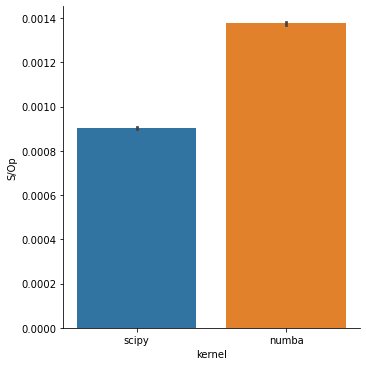

In [6]:
sns.catplot(data=mab, x='kernel', y='time', kind='bar')
plt.ylabel('S/Op')
plt.plot()

### Sweep by Density

We now measure sweeping a 100x100 square matrix multiply by increasing density.

In [7]:
dens = get_runs('MultAB-Density', 'density')

<AxesSubplot:xlabel='density', ylabel='time'>

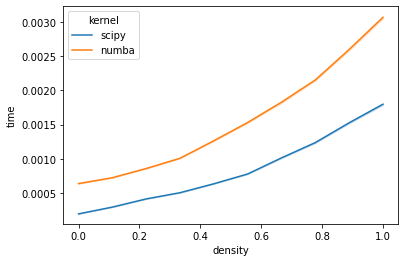

In [8]:
sns.lineplot(data=dens, x='density', y='time', hue='kernel')

## Matrix-Vector Multiplication

Now we'll look at matrix/vector multiplication ($A\vec{x}$)

In [9]:
muax = get_runs('MultAx')
muax.groupby('kernel')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
kernel,,,,,,,,
numba,14010.0,0.000255,0.000087,0.000206,0.000212,0.000215,0.000254,0.002398
scipy,84318.0,0.000050,0.000014,0.000044,0.000046,0.000046,0.000047,0.000488


[]

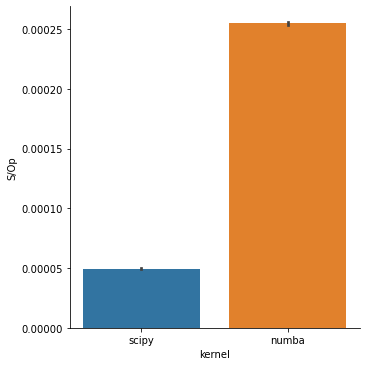

In [10]:
sns.catplot(data=muax, x='kernel', y='time', kind='bar')
plt.ylabel('S/Op')
plt.plot()